<a href="https://colab.research.google.com/github/harmanpreet93/reinforcement-learning-COMP-767/blob/master/n_step_q_learning_sarsa_and_expected_sarsa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import gym
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import pandas as pd
import seaborn as sns

# ! pip install tensorflow==2.1.0
import tensorflow as tf
tf.keras.backend.set_floatx('float64')
tf.__version__

'2.1.0'

**Define a Neural Network with inputs layer as the number of states, outputs layer of size equal to the number of actions, and hidden units = 64. Each of the outout represent the action chosen by our algorithm**

In [0]:
def NN(n_hidden = 64, n_states=4, n_actions=2):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(n_hidden, activation='relu', input_shape=(n_states,)))
    model.add(tf.keras.layers.Dense(n_hidden, activation='relu'))
    model.add(tf.keras.layers.Dense(n_actions))
    return model

model = NN()
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.05),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 4,610
Trainable params: 4,610
Non-trainable params: 0
_________________________________________________________________


#### Helper functions

In [0]:
# choose action based on epsilon-greedy policy
def e_greedy(env, model, state, epsilon):    
    if np.random.random() < epsilon:
        action = env.action_space.sample()
    else:
        input_vector = np.reshape(state, (1,4))
        Q_output = model(input_vector)
        action = np.argmax(Q_output)
    return action

# choose actions greedily
def greedy(env, model, state, epsilon):
    input_vector = np.reshape(state, (1,4))
    Q_output = model(input_vector)
    action = np.argmax(Q_output)
    return action

# train model after sampling experience replay
def experience_replay(model, memory, buffer_size, gamma, epsilon, n_steps=4, algorithm='sarsa'):
    # train only when we have enough elements in the batch
    if len(memory) < buffer_size:
        return
    # sample batch from memory
    memory_batch = random.sample(memory, buffer_size)
    # get training data, based on the old model weights
    X, y = n_step_algorithm(env, model, memory_batch, gamma, epsilon, n_steps, algorithm)
    # train model, and update weights
    model.fit(X, y, epochs=1, batch_size=buffer_size, verbose=0)

def n_step_algorithm(env, model, memory_batch, gamma, epsilon, n_steps=4, algorithm='sarsa'):
    X,y = [], []
    # generate dataset for training 
    for current_state, action, next_state, reward, done in memory_batch:
        X.append(current_state)
        current_state_ = current_state.copy()
        current_state_ = current_state_.reshape((1, 4))
        q_values = model(current_state_).numpy()[0]
        if done:
            q_values[action] = reward
        else:
            next_state_ = next_state.copy()
            next_state_ = next_state_.reshape((1, 4))
            q_values_next = model(next_state_).numpy()[0]
            if algorithm == 'sarsa':
                action = e_greedy(env, model, next_state_, epsilon)
                q_values[action] = reward + (gamma**n_steps) * q_values_next[action]

            elif algorithm == 'q_learning':
                q_values[action] = reward + (gamma**n_steps) * np.max(q_values_next)

            elif algorithm == 'expected_sarsa':
                q_values[action] = reward + (gamma**n_steps) * np.mean(q_values_next)

            else:
                print("Wrong algorithm given")
        y.append(q_values)
    return np.array(X), np.array(y)


def solve_deep_RL_algorithm(env, model, buffer_size=50, n_episodes=10, n_steps=4, gamma=0.9, algorithm='sarsa'):
    memory = [] 
    reward_list = []
    for episode in tqdm(range(n_episodes)):
        done = False
        current_state = env.reset()
        total_reward = 0
        while not done:
            current_step = 0
            first_state = current_state.copy()
            reward_ = 0
            
            while current_step != n_steps:
                if algorithm == 'sarsa' or algorithm == 'expected_sarsa':
                    # choose action based on epsilon-greedy policy
                    action = e_greedy(env, model, current_state, epsilon)
                    # take chosen action
                elif algorithm == 'q_learning':
                    if current_step % 2 == 0:
                        # choose action based on epsilon-greedy policy
                        action = e_greedy(env, model, current_state, epsilon)
                    else:
                        action = greedy(env, model, current_state, epsilon)

                next_state, reward, done, info = env.step(action)
                reward_ += (gamma**current_step) * reward
                # add reward
                total_reward += reward_
                if done:
                    # env.reset()
                    break 
                current_state = next_state
                current_step += 1
            
            # save states and action in memory
            memory.append((first_state, action, next_state, reward_, done))

            if done:
                break

            experience_replay(model, memory, buffer_size, gamma, epsilon, n_steps, algorithm)
        
        reward_list.append(total_reward)
    
    return np.mean(reward_list[-10:])

In [0]:
loss_fn = tf.keras.losses.MeanSquaredError()
rmse = tf.keras.metrics.RootMeanSquaredError()

env = gym.make('CartPole-v1')
# env.reset()

# define paramters
n_episodes = 50
epsilon = 0.1
gamma = 0.9
replay_buffer_size_list = [50, 100, 250, 500]
learning_rate = [0.001, 0.01, 0.1, 0.5]
n_steps = 4

# set seeds
seeds = [i for i in range(0,6,3)]

# choose algorithm
algorithm = 'sarsa'
# algorithm = 'expected_sarsa'
# algorithm = 'q_learning'

print("\n********Training {}-step {} algorithm********".format(n_steps, algorithm.upper()))

rewards_buffer_size_dict = {}
for buffer_size in replay_buffer_size_list:
    rewards_lr_dict = {}
    for lr in learning_rate:        
        lr_seed_list = []
        for seed in seeds:
            # set random seed
            np.random.seed(seed)
            random.seed(seed)
            env.seed(seed)
            tf.random.set_seed(seed)
            env.reset()

            # initialize model, 
            model = NN()
            optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
            model.compile(optimizer=optimizer,
                    loss=loss_fn,
                    metrics=[rmse])
            
            ans = solve_deep_RL_algorithm(env, 
                                        model, 
                                        buffer_size, 
                                        n_episodes, 
                                        n_steps, 
                                        gamma, 
                                        algorithm)
            
            lr_seed_list.append(ans)
        
        rewards_lr_dict[lr] = lr_seed_list

    rewards_buffer_size_dict[buffer_size] = rewards_lr_dict

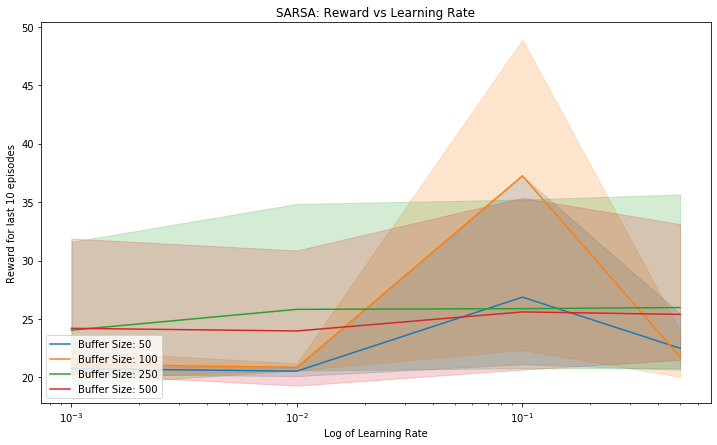

In [0]:
plt.figure(figsize=(12,7))
legend_label = [] 

for key in rewards_buffer_size_dict:
    df = pd.melt(pd.DataFrame(rewards_buffer_size_dict[key]))
    sns.lineplot(x='variable', y='value', data=df)
    legend_label.append('Buffer Size: ' + str(key))

plt.xticks(learning_rate)
plt.xscale("log")
plt.xlabel("Log of Learning Rate")
plt.ylabel("Reward for last 10 episodes")
plt.title("{}: Reward vs Learning Rate".format(algorithm.upper()))

plt.legend(legend_label, loc='lower left');

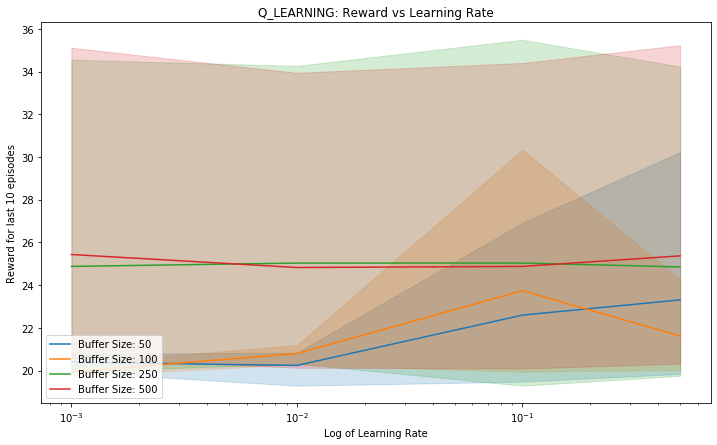

In [0]:
plt.figure(figsize=(12,7))
legend_label = [] 

for key in rewards_buffer_size_dict:
    df = pd.melt(pd.DataFrame(rewards_buffer_size_dict[key]))
    sns.lineplot(x='variable', y='value', data=df)
    legend_label.append('Buffer Size: ' + str(key))

plt.xticks(learning_rate)
plt.xscale("log")
plt.xlabel("Log of Learning Rate")
plt.ylabel("Reward for last 10 episodes")
plt.title("{}: Reward vs Learning Rate".format(algorithm.upper()))

plt.legend(legend_label, loc='lower left');

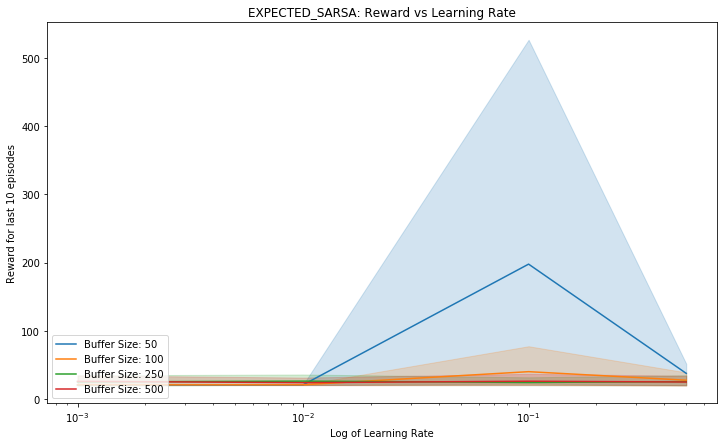

In [0]:
plt.figure(figsize=(12,7))
legend_label = [] 

for key in rewards_buffer_size_dict:
    df = pd.melt(pd.DataFrame(rewards_buffer_size_dict[key]))
    sns.lineplot(x='variable', y='value', data=df)
    legend_label.append('Buffer Size: ' + str(key))

plt.xticks(learning_rate)
plt.xscale("log")
plt.xlabel("Log of Learning Rate")
plt.ylabel("Reward for last 10 episodes")
plt.title("{}: Reward vs Learning Rate".format(algorithm.upper()))

plt.legend(legend_label, loc='lower left');

**What do you observe? Write a brief report on your observations**

Buffer size 500 and learning rate 0.1 are the best combination of experience replay and learning rate for all three algorithms.

In [0]:
def solve_deep_RL_algorithm_rewards(env, model, buffer_size=50, n_episodes=10, n_steps=4, gamma=0.9, algorithm='sarsa'):
    memory = [] 
    reward_list = []
    for episode in tqdm(range(n_episodes)):
        done = False
        current_state = env.reset()
        total_reward = 0
        while not done:
            current_step = 0
            first_state = current_state.copy()
            reward_ = 0
            
            while current_step != n_steps:
                if algorithm == 'sarsa' or algorithm == 'expected_sarsa':
                    # choose action based on epsilon-greedy policy
                    action = e_greedy(env, model, current_state, epsilon)
                    # take chosen action
                elif algorithm == 'q_learning':
                    if current_step % 2 == 0:
                        # choose action based on epsilon-greedy policy
                        action = e_greedy(env, model, current_state, epsilon)
                    else:
                        action = greedy(env, model, current_state, epsilon)

                next_state, reward, done, info = env.step(action)
                reward_ += (gamma**current_step) * reward
                # add reward
                total_reward += reward_
                if done:
                    # env.reset()
                    break 
                current_state = next_state
                current_step += 1
            
            # save states and action in memory
            memory.append((first_state, action, next_state, reward_, done))

            if done:
                break

            experience_replay(model, memory, buffer_size, gamma, epsilon, n_steps, algorithm)
        
        reward_list.append(total_reward)
    
    return reward_list

In [0]:
loss_fn = tf.keras.losses.MeanSquaredError()
rmse = tf.keras.metrics.RootMeanSquaredError()

env = gym.make('CartPole-v1')
# env.reset()

# define paramters
n_episodes = 110
epsilon = 0.1
gamma = 0.9
replay_buffer_size_list = [500]
learning_rate = [0.1]
n_steps = 4

# set seeds
seeds = [i for i in range(0,6,3)]

# choose algorithm
# algorithm = 'sarsa'
# algorithm = 'expected_sarsa'
algorithm = 'q_learning'

print("\n********Training {}-step {} algorithm********".format(n_steps, algorithm.upper()))

rewards_buffer_size_dict = {}
for buffer_size in replay_buffer_size_list:
    rewards_lr_dict = {}
    for lr in learning_rate:        
        lr_seed_list = []
        for seed in seeds:
            # set random seed
            np.random.seed(seed)
            random.seed(seed)
            env.seed(seed)
            tf.random.set_seed(seed)
            env.reset()

            # initialize model, 
            model = NN()
            optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
            model.compile(optimizer=optimizer,
                    loss=loss_fn,
                    metrics=[rmse])
            
            ans = solve_deep_RL_algorithm_rewards(env, 
                                        model, 
                                        buffer_size, 
                                        n_episodes, 
                                        n_steps, 
                                        gamma, 
                                        algorithm)
            
            lr_seed_list.append(ans)
        
        rewards_lr_dict[lr] = lr_seed_list

    rewards_buffer_size_dict[buffer_size] = rewards_lr_dict

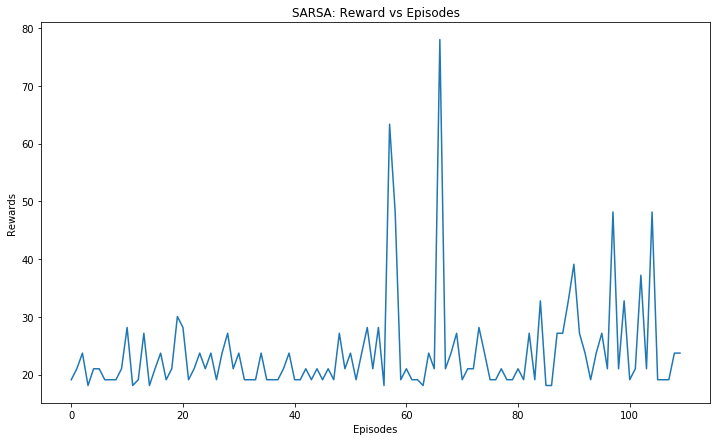

In [0]:
plt.figure(figsize=(12,7))
plt.plot(rewards_buffer_size_dict[500][0.1][0])
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title("{}: Reward vs Episodes".format(algorithm.upper()));

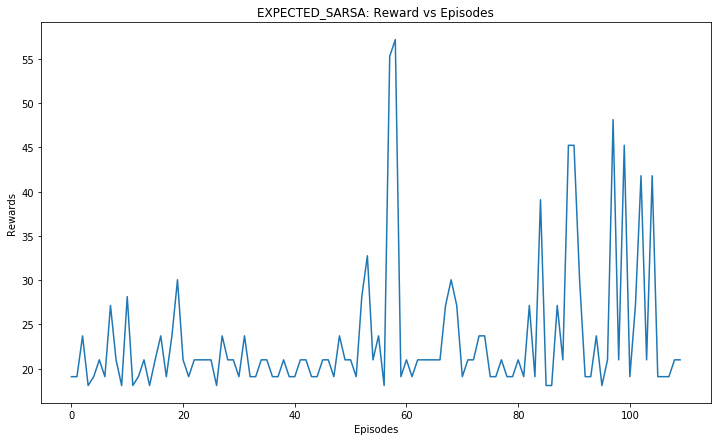

In [0]:
plt.figure(figsize=(12,7))
plt.plot(rewards_buffer_size_dict[500][0.1][0])
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title("{}: Reward vs Episodes".format(algorithm.upper()));

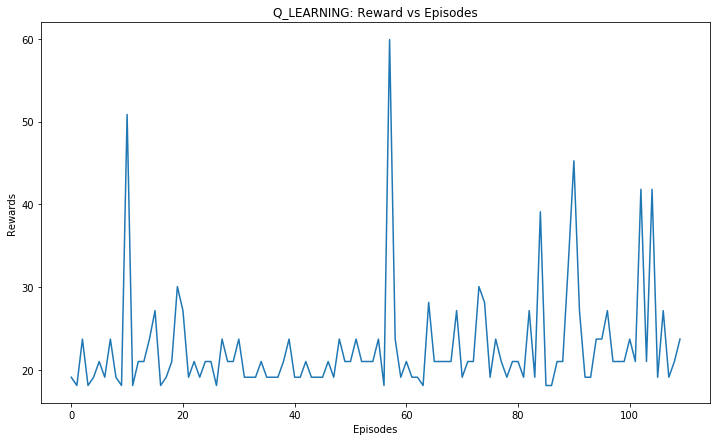

In [0]:
plt.figure(figsize=(12,7))
plt.plot(rewards_buffer_size_dict[500][0.1][0])
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title("{}: Reward vs Episodes".format(algorithm.upper()));

#### Observations:

The experience replay introduces stability, hence we get best results on buffer size of 500. NN learns the representation for us, hence we don't have to do tiling for our inputs for this continuous space in this cartpole example. The rewards are still not converging.